<a href="https://colab.research.google.com/github/mangsshinde/auto_img_capt/blob/master/Image_Captioning_with_Tensorflow_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"mangsshinde","key":"1c002ab573284da68bf701a58aaeaf7e"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

flickr-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip flickr-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5362687336.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [ ]:
input_image_path='/content/flickr30k_images/flickr30k_images'
input_df=pd.read_csv('/content/flickr30k_images/results.csv',on_bad_lines='skip')
image_size=(128,128)
latent_dim=256
epochs=20
input_df.head()

,image_name| comment_number| comment
0,1000092795.jpg| 0| Two young guys with shaggy ...
1,1000092795.jpg| 2| Two men in green shirts are...
2,1000092795.jpg| 3| A man in a blue shirt stand...
3,1000092795.jpg| 4| Two friends enjoy time spen...
4,10002456.jpg| 0| Several men in hard hats are ...


In [ ]:
def split_dataframe(df,samples=55000):
    image_comment_table={}
    print('Making the image comment table')
    num_samples=min(samples,df.shape[0])
    for col in df.columns:
        for sample_index in tqdm(range(num_samples)):
            text=df[col].iloc[sample_index].split('| ')
            image=text[0]
            comment=text[-1]
            if not image in image_comment_table:
                image_comment_table[image]=comment
    print('Making the list of images')
    image_names=[image for image,_ in tqdm(image_comment_table.items())]
    print('Making the list of comments')
    comments=[comment for _,comment in tqdm(image_comment_table.items())]
    return image_names,comments

In [ ]:
image_names,comments=split_dataframe(df=input_df)
del input_df

Making the image comment table


100%|██████████| 55000/55000 [00:00<00:00, 85758.36it/s]


Making the list of images


100%|██████████| 12134/12134 [00:00<00:00, 1319925.43it/s]


Making the list of comments


100%|██████████| 12134/12134 [00:00<00:00, 1760722.53it/s]


In [ ]:
print(image_names[:5])

['1000092795.jpg', '10002456.jpg', '1000268201.jpg', '1000344755.jpg', '1000366164.jpg']


In [ ]:
def make_image_list(image_path,image_names,image_size=(128,128)):
    images=[]
    for image_name in tqdm(image_names):
        image_filepath=os.path.join(image_path,image_name)
        image=cv2.imread(image_filepath)
        image=cv2.resize(image,image_size)
        images.append(image/255.)
    return images

In [ ]:
images=make_image_list(
    image_path=input_image_path,image_names=image_names,
    image_size=image_size
)
del image_names

100%|██████████| 12134/12134 [01:20<00:00, 151.17it/s]


In [ ]:
def plot_images(images,row,col):
    fig=plt.figure(figsize=(16,16))
    for i in range(len(images)):
        fig.add_subplot(row,col,i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.tight_layout()
    plt.show()

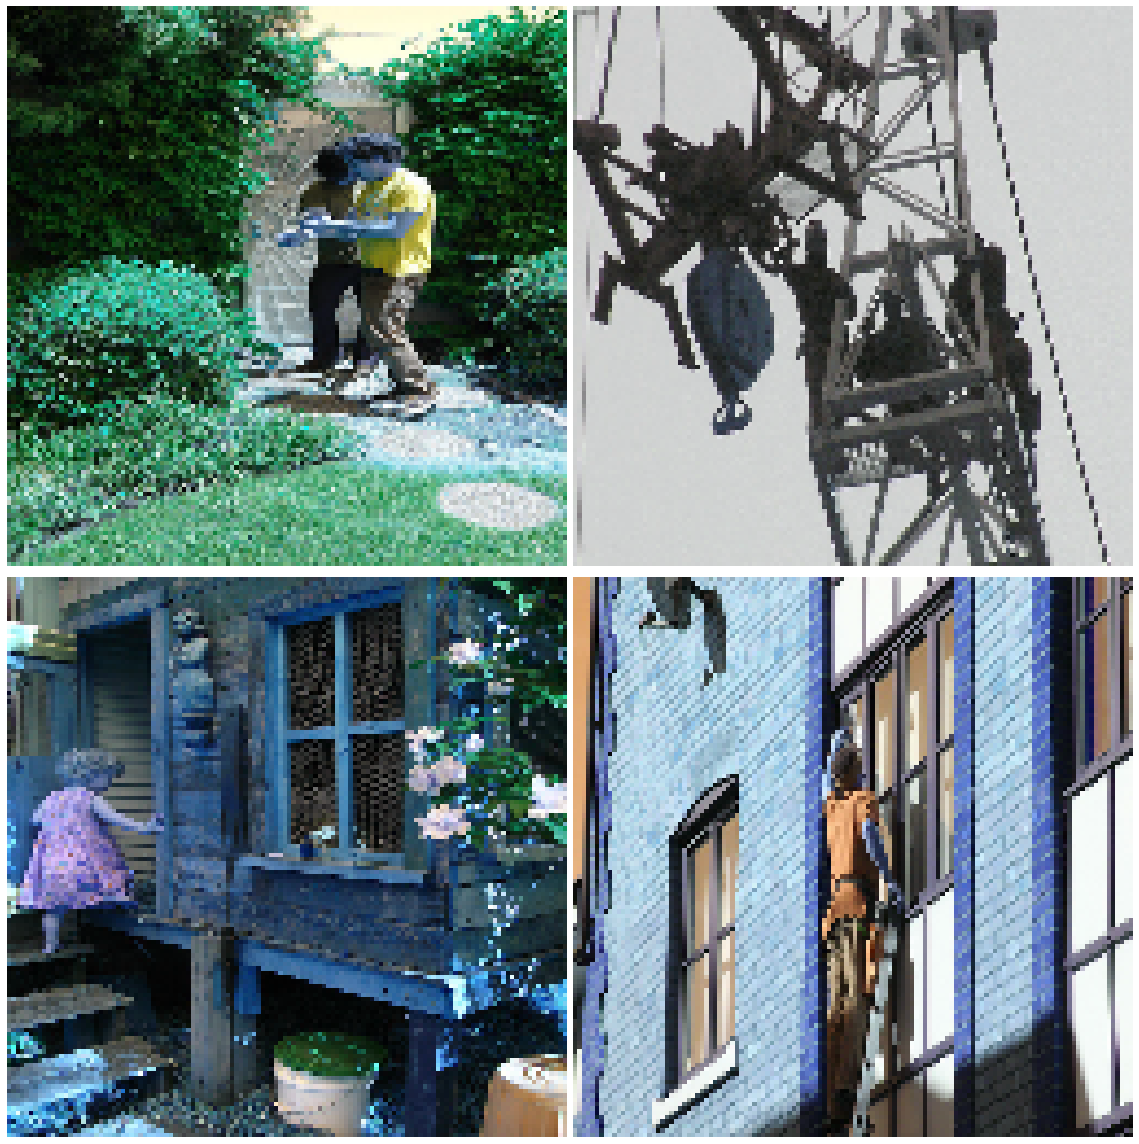

In [ ]:
plot_images(images[:4],row=2,col=2)

In [ ]:
print(comments[:5])

['Two young guys with shaggy hair look at their hands while hanging out in the yard .', 'Several men in hard hats are operating a giant pulley system .', 'A child in a pink dress is climbing up a set of stairs in an entry way .', 'Someone in a blue shirt and hat is standing on stair and leaning against a window .', 'Two guy cooking and joking around with the camera .']


In [ ]:
def generate_text_with_start_and_end_tokens(text_list):
    char_set=set()
    input_sequence_length=0
    text_data=[]
    for text in tqdm(text_list):
        text=text.lower()
        text=re.sub('[^a-z0-9\s]','',text)
        text='\t'+text+'\n'
        text_data.append(text)
        for char in text:
            if not char in char_set:
                char_set.add(char)
        input_sequence_length=max(input_sequence_length,len(text))
    char_set=sorted(list(char_set))
    return text_data,char_set,input_sequence_length

In [ ]:
text_data,char_set,input_sequence_length=generate_text_with_start_and_end_tokens(comments)
del comments

100%|██████████| 12134/12134 [00:00<00:00, 127412.91it/s]


In [ ]:
print(char_set)

['\t', '\n', ' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
chars_to_tokens={char:num for num,char in enumerate(char_set)}
print(chars_to_tokens)

{'\t': 0, '\n': 1, ' ': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'k': 23, 'l': 24, 'm': 25, 'n': 26, 'o': 27, 'p': 28, 'q': 29, 'r': 30, 's': 31, 't': 32, 'u': 33, 'v': 34, 'w': 35, 'x': 36, 'y': 37, 'z': 38}


In [ ]:
tokens_to_chars={num:char for char,num in chars_to_tokens.items()}
print(tokens_to_chars)

{0: '\t', 1: '\n', 2: ' ', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: 'a', 14: 'b', 15: 'c', 16: 'd', 17: 'e', 18: 'f', 19: 'g', 20: 'h', 21: 'i', 22: 'j', 23: 'k', 24: 'l', 25: 'm', 26: 'n', 27: 'o', 28: 'p', 29: 'q', 30: 'r', 31: 's', 32: 't', 33: 'u', 34: 'v', 35: 'w', 36: 'x', 37: 'y', 38: 'z'}


In [ ]:
print(input_sequence_length)

302


In [ ]:
vocab_size=len(char_set)
num_comments=len(text_data)
print(f'Number of comments: {num_comments}')
print(f'Number of characters: {vocab_size}')

Number of comments: 12134
Number of characters: 39


In [ ]:
def one_hot_encode_text(text_list):
    one_input_hot_text=np.zeros(shape=(num_comments,input_sequence_length,vocab_size))
    one_output_hot_text=np.zeros(shape=(num_comments,input_sequence_length,vocab_size))
    for text_index,text in enumerate(text_list):
        for char_index,char in enumerate(text):
            one_input_hot_text[text_index,char_index,chars_to_tokens[char]]=1
        one_input_hot_text[text_index,char_index+1:,chars_to_tokens[' ']]=1
        for char_index,char in enumerate(text):
            if char_index>1:
                one_output_hot_text[text_index,char_index-1,chars_to_tokens[char]]=1
        one_output_hot_text[text_index,char_index:,chars_to_tokens[' ']]=1
    return one_input_hot_text,one_output_hot_text

In [ ]:
one_input_hot_text,one_output_hot_text=one_hot_encode_text(text_data)
del text_data

In [ ]:
def decode_one_hot_text(text):
    ans=''
    for position in text[1:-1]:
        char_index=np.argmax(position,axis=-1)
        ans+=tokens_to_chars[char_index]
    return ans

In [ ]:
for encoded_text in one_input_hot_text[:5]:
    print(decode_one_hot_text(encoded_text))

two young guys with shaggy hair look at their hands while hanging out in the yard 
                                                                                                                                                                                                                         
several men in hard hats are operating a giant pulley system 
                                                                                                                                                                                                                                              
a child in a pink dress is climbing up a set of stairs in an entry way 
                                                                                                                                                                                                                                    
someone in a blue shirt and hat is standing on stair and leaning against a window 
              

In [ ]:
def permute_indices(length,split_pct=70):
    idxs=np.random.permutation(length)
    train_idxs=idxs[:length*split_pct//100]
    valid_idxs=idxs[length*split_pct//100:]
    return train_idxs,valid_idxs

In [ ]:
def delete_idxs(data,idxs):
    print('Deleting.......')
    for idx in tqdm(idxs):
        del data[idx]

In [ ]:
def make_dataset(images,input_comments,target_comments,idxs):
    image_data=[images[idx] for idx in tqdm(idxs)]
    delete_idxs(image,idxs)
    input_comments_data=[input_comments[idx] for idx in tqdm(idxs)]
    delete_idxs(input_comments_data,idxs)
    target_comments_data=[target_comments[idx] for idx in tqdm(idxs)]
    delete_idxs(target_comments_data,idxs)
    image_data=tf.convert_to_tensor(image_data)
    input_comments_data=tf.convert_to_tensor(input_comments_data)
    target_comments_data=tf.convert_to_tensor(target_comments_data)
    return image_data,input_comments_data,target_comments_data

In [ ]:
train_idxs,valid_idxs=permute_indices(num_comments,split_pct=80)

In [ ]:
train_image,train_input_comments,train_target_comments=make_dataset(
    images=images,
    input_comments=one_input_hot_text,
    target_comments=one_output_hot_text,
    idxs=train_idxs
)

100%|██████████| 9707/9707 [00:00<00:00, 735841.48it/s]


Deleting.......


  0%|          | 37/9707 [00:00<00:00, 90069.21it/s]


IndexError: ignored

In [ ]:
valid_idxs

array([7854, 2535, 2547, ..., 3265, 1792, 8802])